<a href="https://colab.research.google.com/github/AryanC2576/Quant_fin/blob/main/btc_m20_momentum_strat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install yfinance




In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

In [11]:
def get_yfinance_data(symbol='BTC-USD', start_date=None, end_date=None):
    """
    Fetches historical stock/crypto data from Yahoo Finance using yfinance.
    """
    if start_date is None:
        # Default to a year ago if no start date is provided
        start_date = (datetime.now() - timedelta(days=365*3)).strftime('%Y-%m-%d') # Fetch 3 years for better MA calculation
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')

    try:
        data = yf.download(symbol, start=start_date, end=end_date)
        # Simplify the column index by resetting it and dropping the 'Ticker' level
        data = data.reset_index()
        data.columns = data.columns.droplevel(1) # Drop the 'Ticker' level
        # Set 'Date' as the index again if needed, or just keep it as a column
        # data = data.set_index('Date') # Optional: set Date as index again
        return data
    except Exception as e:
        print(f"Error fetching data from Yahoo Finance: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

In [12]:
# Fetch BTC/USD data from Yahoo Finance
print("Fetching BTC-USD data from Yahoo Finance...")
# Use 'BTC-USD' as the symbol for Bitcoin against USD on Yahoo Finance
df_candles = get_yfinance_data(symbol='BTC-USD')

if not df_candles.empty:
    print(f"Successfully fetched {len(df_candles)} daily candles from Yahoo Finance.")
    # yfinance already returns columns like 'Open', 'High', 'Low', 'Close', 'Volume'
    print(df_candles.head())
else:
    print("Could not fetch BTC-USD data from Yahoo Finance. Exiting.")
    exit()

/tmp/ipython-input-11-1071339375.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Fetching BTC-USD data from Yahoo Finance...
Successfully fetched 1095 daily candles from Yahoo Finance.
Price       Date         Close          High           Low          Open  \
0     2022-07-21  23164.628906  23388.322266  22431.148438  23233.201172   
1     2022-07-22  22714.978516  23671.927734  22603.416016  23163.751953   
2     2022-07-23  22465.478516  22977.210938  22002.910156  22706.984375   
3     2022-07-24  22609.164062  22974.001953  22306.839844  22465.509766   
4     2022-07-25  21361.701172  22649.121094  21361.642578  22607.156250   

Price       Volume  
0      33631012204  
1      31421555646  
2      24021799169  
3      23565495303  
4      35574561406  


In [13]:
window = 20
# Ensure there are enough data points for the rolling mean
if len(df_candles) < window:
    print(f"Not enough data points ({len(df_candles)}) to calculate {window}-day MA. Exiting.")
    exit()

df_candles['MA'] = df_candles['Close'].rolling(window=window).mean()

# Generate signals
df_candles['Signal'] = 0
df_candles.loc[df_candles['Close'] > df_candles['MA'], 'Signal'] = 1 # Use .loc for SettingWithCopyWarning
df_candles['Signal'] = df_candles['Signal'].shift(1).fillna(0) # Shift signal to avoid look-ahead bias

# Calculate daily returns for the asset
df_candles['Daily_Return'] = df_candles['Close'].pct_change()

# Calculate strategy returns
df_candles['Strategy_Return'] = df_candles['Daily_Return'] * df_candles['Signal']

# --- SECTION 3: Performance Calculation ---
# Dummy Label: Replace with your commentary on calculating cumulative returns and Sharpe Ratio.

# Calculate cumulative returns
df_candles['Cumulative_Buy_And_Hold'] = (1 + df_candles['Daily_Return']).cumprod()
df_candles['Cumulative_Strategy'] = (1 + df_candles['Strategy_Return']).cumprod()

In [14]:
excess_daily_returns = df_candles['Strategy_Return'].dropna()

if not excess_daily_returns.empty:
    daily_avg_return = excess_daily_returns.mean()
    daily_std_dev = excess_daily_returns.std()

    if daily_std_dev != 0:
        daily_sharpe = daily_avg_return / daily_std_dev
        annualized_sharpe = daily_sharpe * np.sqrt(365) # Using 365 for crypto
    else:
        annualized_sharpe = np.nan
        print("Standard deviation of strategy returns is zero, cannot calculate Sharpe Ratio.")
else:
    annualized_sharpe = np.nan
    print("No excess daily returns to calculate Sharpe Ratio.")

print(f"\nAnnualized Sharpe Ratio: {annualized_sharpe:.2f}")


Annualized Sharpe Ratio: 0.97


In [15]:
# Get the last value of the 'Cumulative_Buy_And_Hold' column
final_cumulative_buy_and_hold = df_candles['Cumulative_Buy_And_Hold'].iloc[-1]

# Get the last value of the 'Cumulative_Strategy' column
final_cumulative_strategy = df_candles['Cumulative_Strategy'].iloc[-1]

print(f"\n--- Cumulative Returns ---")
print(f"Final Cumulative Return (Buy and Hold): {final_cumulative_buy_and_hold:.2f}x")
print(f"Final Cumulative Return (MA Strategy): {final_cumulative_strategy:.2f}x")

# If you want it as a percentage:
print(f"Final Percentage Return (Buy and Hold): {(final_cumulative_buy_and_hold - 1) * 100:.2f}%")
print(f"Final Percentage Return (MA Strategy): {(final_cumulative_strategy - 1) * 100:.2f}%")



--- Cumulative Returns ---
Final Cumulative Return (Buy and Hold): 5.09x
Final Cumulative Return (MA Strategy): 2.31x
Final Percentage Return (Buy and Hold): 409.14%
Final Percentage Return (MA Strategy): 130.81%


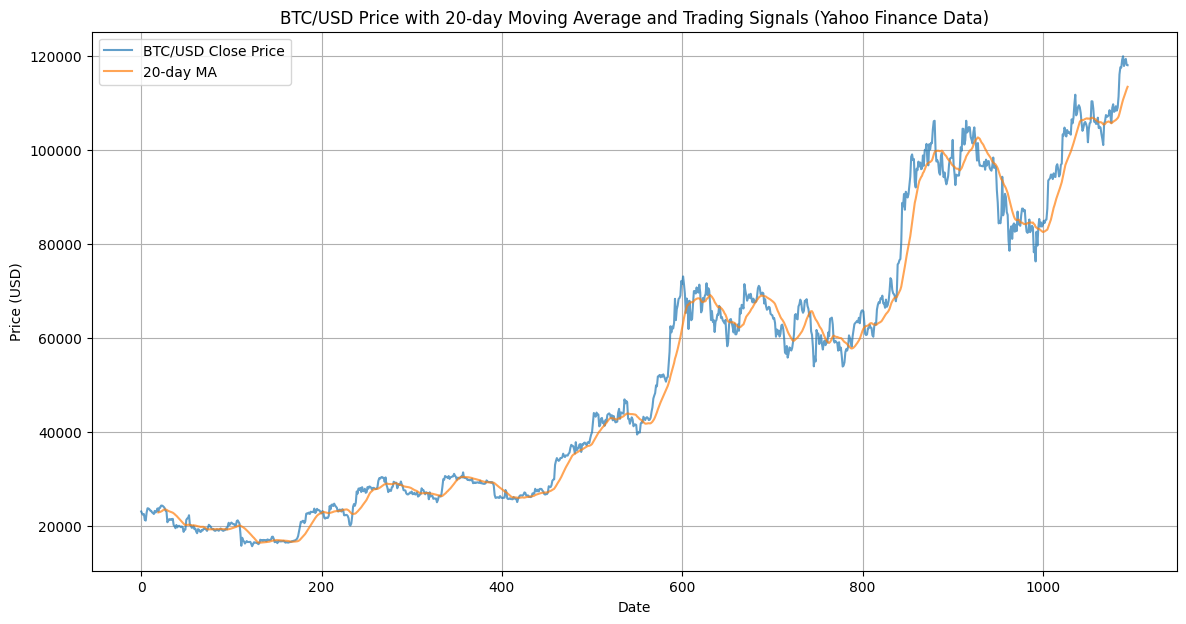

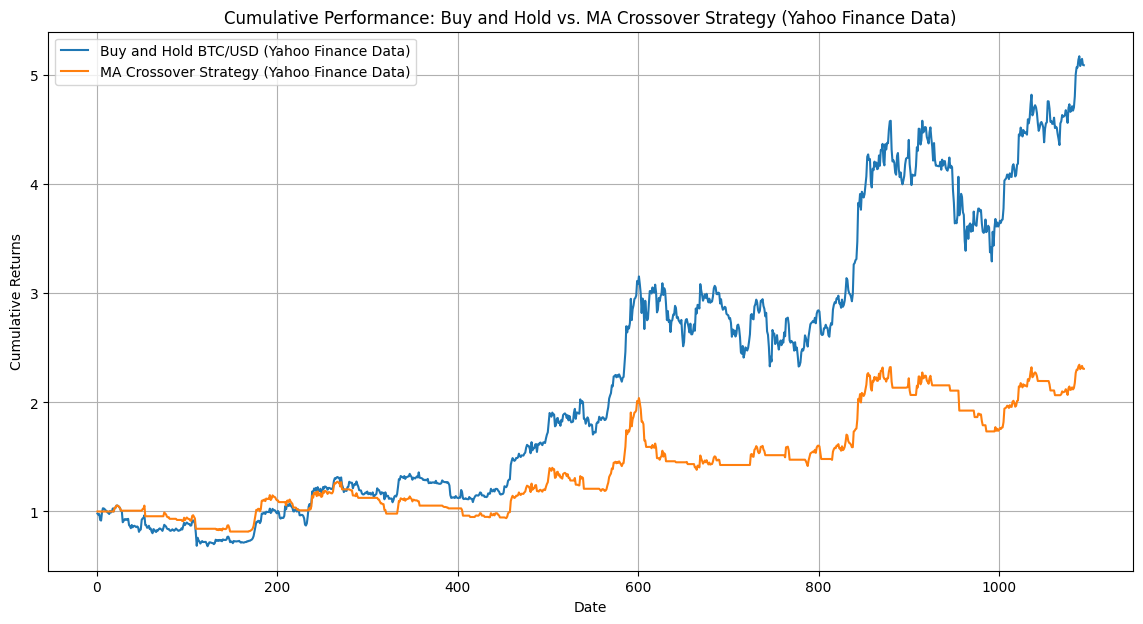

In [16]:
# Plot 1: Price and MA
plt.figure(figsize=(14, 7))
plt.plot(df_candles.index, df_candles['Close'], label='BTC/USD Close Price', alpha=0.7)
plt.plot(df_candles.index, df_candles['MA'], label=f'{window}-day MA', alpha=0.7)
plt.title('BTC/USD Price with 20-day Moving Average and Trading Signals (Yahoo Finance Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Cumulative Performance
plt.figure(figsize=(14, 7))
plt.plot(df_candles.index, df_candles['Cumulative_Buy_And_Hold'], label='Buy and Hold BTC/USD (Yahoo Finance Data)')
plt.plot(df_candles.index, df_candles['Cumulative_Strategy'], label='MA Crossover Strategy (Yahoo Finance Data)')
plt.title('Cumulative Performance: Buy and Hold vs. MA Crossover Strategy (Yahoo Finance Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()